In [1]:
import itertools
import typing
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from gym import Env, spaces
from neuronav.envs.graph_env import GraphObsType
import neuronav.utils as utils
from neuronav.agents.base_agent import BaseAgent
from neuronav.agents.td_agents import TDQ, TDAC, TDSR
from neuronav.agents.mb_agents import MBV, SRMB
from neuronav.agents.dyna_agents import DynaQ, DynaAC, DynaSR
from neuronav.notebook_helpers import AgentParams

import gym_minigrid
from gym_minigrid.envs import numbertasks
from gym_minigrid.envs.numbertasks import NumberTaskType

In [35]:
N_STIMULI_STATES = 20
N_TERMINAL_STATES = 2
SINGLE_TASK_N_ACTIONS = 2
NEURONAV_DEFAULT_RESET_KEYS = ('agent_pos', 'reward_locs', 'random_start')

class NumberTasksEnv(Env):
    def __init__(self, task: NumberTaskType, obs_type: GraphObsType = GraphObsType.index, 
        switch_tasks: bool = False, multi_task: bool = False, remap_actions: bool = False, 
        task_switch_interval: int = 1, seed: int = 33):
        self.task = task
        self.obs_type = obs_type

        if multi_task and not switch_tasks:
            raise ValueError('Multi-task requires switching tasks')

        self.switch_tasks = switch_tasks
        self.multi_task = multi_task
        self.remap_actions = remap_actions

        self.task_switch_interval = task_switch_interval
        self.seed = seed
        self.rng = np.random.RandomState(seed)

        self.n_actions = SINGLE_TASK_N_ACTIONS if not self.multi_task else SINGLE_TASK_N_ACTIONS * len(NumberTaskType)
        self.action_permutations = list(itertools.permutations(range(self.n_actions))) if self.remap_actions else [list(range(self.n_actions))]
        self.n_action_permutations = len(self.action_permutations)
        self.state_size = N_STIMULI_STATES * self.n_action_permutations + N_TERMINAL_STATES

        if obs_type == GraphObsType.index:
            self.observation_space = spaces.Box(0, self.state_size, shape=(1,), dtype=np.int32)

        elif obs_type == GraphObsType.onehot:
            self.observation_space = spaces.Box(0, 1, shape=(self.state_size,), dtype=np.int32)

        elif obs_type == GraphObsType.images:
            raise ValueError('Not implemented')

        self.action_space = spaces.Discrete(self.n_actions)

        self.last_stimulus = None
        self.action_permutation_index = 0
        self.steps_since_switch = 0
        

    def reset(self, seed: typing.Optional[int] = None, **kwargs):
        for key in NEURONAV_DEFAULT_RESET_KEYS:
            if key in kwargs:
                kwargs.pop(key)

        super().reset(seed=seed, **kwargs)
        return self.observation

    @property
    def observation(self):
        if self.switch_tasks and self.steps_since_switch >= self.task_switch_interval:
            self.task = self.rng.choice(list(NumberTaskType))
            self.steps_since_switch = 0

        self.steps_since_switch += 1

        if self.remap_actions:
            self.action_permutation_index = self.rng.randint(0, self.n_action_permutations)

        self.last_stimulus = self.rng.randint(0, N_STIMULI_STATES) + (self.action_permutation_index * N_STIMULI_STATES)
        return self._index_to_observation(self.last_stimulus)
        
    def _index_to_observation(self, obs_index: int):
        if self.obs_type == GraphObsType.onehot:
            return utils.onehot(obs_index, self.state_size)
        elif self.obs_type == GraphObsType.index:
            return obs_index
        else:
            return None

    def step(self, action: int):
        """
        Assumes that 0-9 are the digits in red and 10-19 are the digits in green
        Color task: 0 is red, 1 is green
        Magnitude task: 0 is -, 1 is +
        Parity task: 0 is even, 1 is odd
        """
        if self.last_stimulus is None:
            raise ValueError('No stimulus has been set yet')

        stimulus = self.last_stimulus % N_STIMULI_STATES
        action_permutation = self.action_permutations[self.action_permutation_index]
        action = action_permutation[action]

        if self.multi_task:
            if self.task == NumberTaskType.color and action < 2:
                reward = 1 if (stimulus >= 10) == (action == 1) else -1

            elif self.task == NumberTaskType.magnitude and 2 < action < 4:
                action -= 2
                digit = stimulus % 10
                reward = 1 if (digit >= 5) == (action == 1) else -1

            elif self.task == NumberTaskType.parity and action >= 4:
                action -= 4
                reward = 1 if (stimulus % 2) == action else -1
            
            else: 
                reward = -1

        else:
            if self.task == NumberTaskType.color:
                reward = 1 if (stimulus >= 10) == (action == 1) else -1

            elif self.task == NumberTaskType.magnitude:
                digit = stimulus % 10
                reward = 1 if (digit >= 5) == (action == 1) else -1

            elif self.task == NumberTaskType.parity:
                reward = 1 if (stimulus % 2) == action else -1
        
        # last two states are terminal ones, one for success and one for failure
        next_obs_index_increment = 2 if (reward == 1) else 1
        next_obs_index = self.state_size - next_obs_index_increment

        return self._index_to_observation(next_obs_index), reward, True, {}


In [48]:
AGENT_PARAMS = AgentParams(
    poltype="softmax",
    beta=10.0,
    epsilon=0.1,
    lr=1e-1,
    gamma=0.9,
)

N_EPISODES = 1000
MAX_STEPS = 1000

AGENT_TYPES = {
    'TDQ': TDQ, 'TDAC': TDAC, "TDSR": TDSR, 
    'DynaQ': DynaQ, 'DynaAC': DynaAC, 'DynaSR': DynaSR, 
    'MBV': MBV, 'SRMB': SRMB, 
}


In [49]:
DEFAULT_MOVING_AVERAGE_WINDOW = 50


def moving_average(a, n=DEFAULT_MOVING_AVERAGE_WINDOW) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def run_and_plot_multiple_agents(env: Env, agent_types: typing.Dict[str, typing.Type[BaseAgent]] = AGENT_TYPES,
    agent_params: AgentParams = AGENT_PARAMS, 
    n_episodes: int = N_EPISODES, max_steps: int = MAX_STEPS,
    moving_average_window: int = DEFAULT_MOVING_AVERAGE_WINDOW,
    ax: typing.Optional[plt.Axes] = None, title: str = '', 
    colormap: matplotlib.colors.Colormap = plt.cm.Dark2,
    show_legend: bool = True, legend_loc: str = 'best',
    legend_bbox_to_anchor: typing.Optional[typing.Tuple[float, float]] = None,):
    
    agent_rewards = {}
    agents = {}

    for agent_type, agent_class in agent_types.items():
        agent = agent_class(env.state_size, env.action_space.n, **agent_params.__dict__)
        agent, rewards = utils.run_multiple_episodes(env, agent, n_episodes, max_steps)
        agent_rewards[agent_type] = moving_average(rewards, moving_average_window)
        agents[agent_type] = agent

    if ax is None:
        _, ax = plt.subplots()

    for i, (agent_type, agent_rewards) in enumerate(agent_rewards.items()):
        ax.plot(agent_rewards, label=agent_type, color=colormap(i))

    if show_legend:
        ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox_to_anchor)

    ax.set_xlabel('Steps')
    ax.set_ylabel(f'Reward ({moving_average_window}-step average)')
    ax.set_title(title)

    return agents


DEFAULT_SIZE_PER_AX = 4
DEFAULT_SUBPLOT_ADJUSTMENTS = dict(top=0.85)


def run_multiple_envs_multiple_agents(envs: typing.Sequence[NumberTasksEnv],
    # Simulation parameters
    agent_types: typing.Dict[str, typing.Type[BaseAgent]] = AGENT_TYPES,
    agent_params: AgentParams = AGENT_PARAMS, 
    n_episodes: int = N_EPISODES, 
    max_steps: int = MAX_STEPS,
    moving_average_window: int = DEFAULT_MOVING_AVERAGE_WINDOW,
    # Plotting parameters
    subplots_layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[int, int]] = None,
    subplots_adjustments: typing.Optional[typing.Dict[str, float]] = DEFAULT_SUBPLOT_ADJUSTMENTS,
    fig_width_per_ax: int = DEFAULT_SIZE_PER_AX,
    fig_height_per_ax: int = DEFAULT_SIZE_PER_AX,
    ax_titles: typing.Optional[typing.Sequence[str]] = None,
    legend_index: int = 0,
    legend_loc: str = 'best',
    legend_bbox_to_anchor: typing.Optional[typing.Tuple[float, float]] = None,
    colormap: matplotlib.colors.Colormap = plt.cm.Dark2,
    suptitle: str = '',
    suptitle_fontsize: int = 16,):

    if subplots_layout is None:
        subplots_layout = (1, len(envs))

    if figsize is None:
        figsize = (subplots_layout[1] * fig_width_per_ax, subplots_layout[0] * fig_height_per_ax)

    if ax_titles is None:
        ax_titles = [''] * len(envs)

    _, axes = plt.subplots(*subplots_layout, figsize=figsize)
    plt.subplots_adjust(**subplots_adjustments)

    all_trained_agents = []

    for index, (env, ax_title) in enumerate(zip(envs, ax_titles)):
        agents = run_and_plot_multiple_agents(env, 
            agent_types=agent_types, agent_params=agent_params, 
            n_episodes=n_episodes, max_steps=max_steps, 
            moving_average_window=moving_average_window,
            ax=axes[index] if len(envs) > 1 else axes, 
            colormap=colormap, title=ax_title, 
            show_legend=index == legend_index, legend_loc=legend_loc,
            legend_bbox_to_anchor=legend_bbox_to_anchor,
        )
        all_trained_agents.append(agents)

    plt.suptitle(suptitle, fontsize=suptitle_fontsize)
    plt.show()

    return all_trained_agents


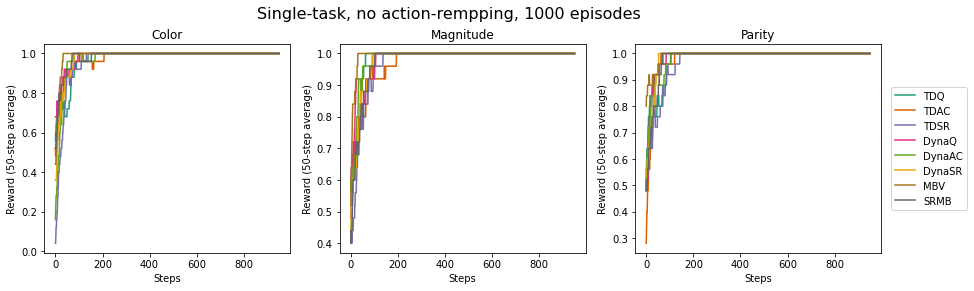

In [50]:
episodes = 1000

envs = [NumberTasksEnv(task=task, multi_task=False, obs_type=GraphObsType.index) for task in NumberTaskType]
titles = [task.name.capitalize() for task in NumberTaskType]

all_agents = run_multiple_envs_multiple_agents(envs, ax_titles=titles, suptitle=f'Single-task, no action-rempping, {episodes} episodes', n_episodes=episodes,
    legend_index=2, legend_loc='center left', legend_bbox_to_anchor=(1.02, 0.5), fig_width_per_ax=5)

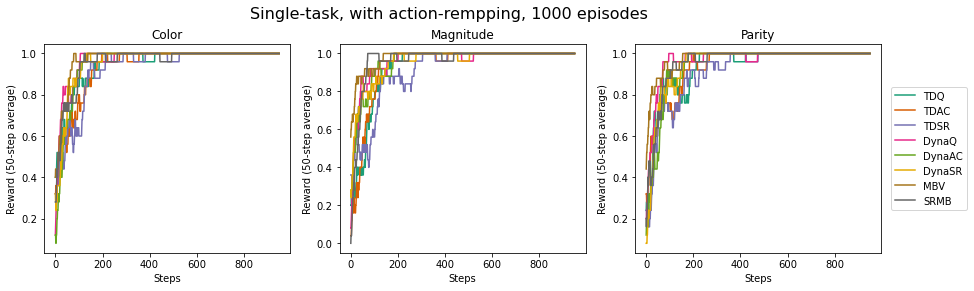

In [51]:
episodes = 1000

envs = [NumberTasksEnv(task=task, multi_task=False, remap_actions=True, obs_type=GraphObsType.index) for task in NumberTaskType]
titles = [task.name.capitalize() for task in NumberTaskType]

all_agents = run_multiple_envs_multiple_agents(envs, ax_titles=titles, suptitle=f'Single-task, with action-rempping, {episodes} episodes', n_episodes=episodes,
    legend_index=2, legend_loc='center left', legend_bbox_to_anchor=(1.02, 0.5), fig_width_per_ax=5)

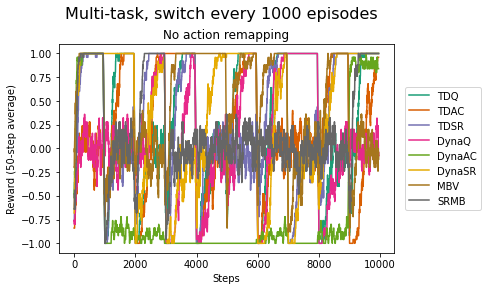

In [52]:
TASK_SWITCH_INTERVAL = 1000

envs = [NumberTasksEnv(task=NumberTaskType.color, multi_task=True, switch_tasks=True,
    remap_actions=False, task_switch_interval=TASK_SWITCH_INTERVAL, obs_type=GraphObsType.index)]
titles = ['No action remapping'] # , 'With action remapping']

task_switch_agents = run_multiple_envs_multiple_agents(envs, ax_titles=titles, n_episodes=10 * TASK_SWITCH_INTERVAL,
    suptitle=f'Multi-task, switch every {TASK_SWITCH_INTERVAL} episodes', # without/with action-rempping', 
    legend_index=0, legend_loc='center left', legend_bbox_to_anchor=(1.02, 0.5), fig_width_per_ax=6)


In [ ]:
envs = [NumberTasksEnv(task=NumberTaskType.color, multi_task=True, switch_tasks=True,
    remap_actions=remap, obs_type=GraphObsType.index) for remap in [False, True]]
titles = ['No action remapping', 'With action remapping']


run_multiple_envs_multiple_agents(envs, ax_titles=titles, n_steps=1000,
    suptitle='Multi-task, without/with action-rempping', 
    legend_index=2, legend_loc='center left', legend_bbox_to_anchor=(1.02, 0.5), fig_width_per_ax=5)


KeyboardInterrupt: 

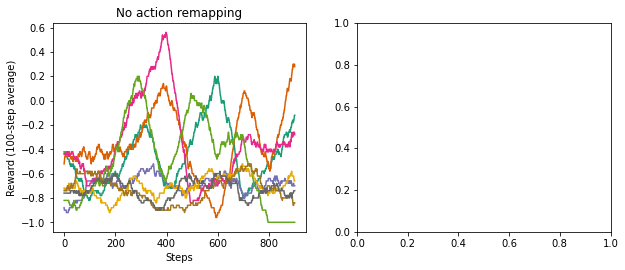

In [5]:
TASK_SWITCH_INTERVAL = 100

envs = [NumberTasksEnv(task=NumberTaskType.color, multi_task=True, switch_tasks=True,
    remap_actions=remap, task_switch_interval=TASK_SWITCH_INTERVAL, obs_type=GraphObsType.index) for remap in [False, True]]
titles = ['No action remapping', 'With action remapping']

run_multiple_envs_multiple_agents(envs, ax_titles=titles, n_steps=1000,
    suptitle=f'Multi-task, switch every {TASK_SWITCH_INTERVAL} steps, without/with action-rempping', 
    legend_index=2, legend_loc='center left', legend_bbox_to_anchor=(1.02, 0.5), fig_width_per_ax=5)


{0: 0.54, 1: 0.5, 2: 0.55, 3: 0.47, 4: 0.45, 5: 0.47, 6: 0.6, 7: 0.54, 8: 0.51, 9: 0.48, 10: 0.45, 11: 0.58, 12: 0.45, 13: 0.49, 14: 0.49, 15: 0.49, 16: 0.44, 17: 0.54, 18: 0.46, 19: 0.53}


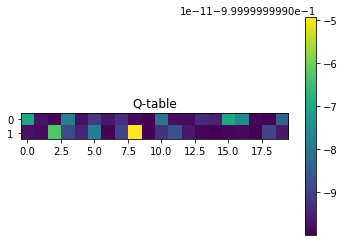

In [37]:
sampled_actions = {
    s: np.mean([agents['TDQ'].sample_action(s) for _ in range(100)])
    for s in range(N_STATES)
}
print(sampled_actions)
    

plt.imshow(agents['TDQ'].Q)
plt.colorbar()
plt.title(f'Q-table')
plt.show()

In [ ]:
task_switch_env = NumberTasksEnv(task=task, obs_type=GraphObsType.index, switch_tasks=True)
task_switch_q_agent = TDQ(task_switch_env.state_size, task_switch_env.action_space.n, **AGENT_PARAMS.__dict__)

utils.run_episode(task_switch_env, task_switch_q_agent, N_STEPS * 10)
plt.imshow(task_switch_q_agent.Q)
plt.colorbar()
plt.title(f'Task Switching Q-table')
plt.show()

In [ ]:
multi_task_switch_env = NumberTasksEnv(task=task, obs_type=GraphObsType.index, switch_tasks=True, multi_task=True)
multi_task_switch_q_agent = TDQ(multi_task_switch_env.state_size, multi_task_switch_env.action_space.n, **AGENT_PARAMS.__dict__)

utils.run_episode(multi_task_switch_env, multi_task_switch_q_agent, N_STEPS * 10)
plt.imshow(multi_task_switch_q_agent.Q)
plt.colorbar()
plt.title(f'Task Switching with multiple outputs Q-table')
plt.show()

In [61]:
env = NumberTasksEnv(task=NumberTaskType.parity, obs_type=GraphObsType.index, multi_task=False, remap_actions=True)
env.reset()

9

In [68]:
env.step(1)

(7, 1, False, {})